# Simple logistic model with uncertainty
We want
- Logistic regression 
- LASSO/Ridge regularization
- Uncertainty quantification and prior-ification

## Model
Let $Y_{it}$ be the Republican _score_, defined as the proportion of votes Republican received over the total votes received by Republican and Democratic candidates. Let $W_{it}$ be whether the Republican wins.

Assume that 
$$
Y_{it} \sim \mathcal{N}(X\beta, \sigma^2)
$$
We infer $\beta$ via a penalized logistic regression with cross-validation selection of the penalities. We infer $\sigma^2$ by simply taking the variance of the prediction errors.

On the test set, assume that polls are drawn from $\text{Bin}(n, Y) \approx \mathcal{N}(nY, nY(1-Y))$. This is a normal likelihood with normal prior Bayesian model, and the posterior is easy to compute.

In [1]:
import us

In [2]:
import glmnet_python
import geopandas as gpd
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict
sns.set_style('white')
plt.rcParams['figure.dpi'] = 150


In [3]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [4]:
past = pd.read_feather('past_house.feather')
past['total_votes'] = past['demvotes'].fillna(0) + past['repvotes'].fillna(0)
past = past[['state','raceyear', 'areanumber', 'total_votes']].copy()
past.columns = ['state', 'raceyear', 'district', 'total_votes']

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [5]:
df = pd.read_feather('data/final_merged.feather')
df['raceyear'] = df['year']

cols = ['rep_incumbent', 'dem_incumbent', 'dem_is_female', 'rep_is_female',
       'dem_percent', 'minority_percentage', 'pres_approval', 'same_as_pres_party_rep',
       'same_as_pres_party_dem', 'log_med_income', 'percent_bachelor_or_above',]

df.loc[df['raceyear'] == 2018, cols] = (df.loc[df['raceyear'] == 2018, cols]
                                        .fillna(df.loc[df['raceyear'] == 2018, cols]
                                                .mean()))

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [6]:
df = df.merge(past, how='left')

In [7]:
state = pd.get_dummies(df['state']).iloc[:,:-1]

In [8]:
df = pd.concat([df, state], axis=1, sort=False)

In [9]:
not_failing = (df[cols].isnull().sum(axis=1) <= 3) & (df['raceyear'] < 2018)
df.loc[not_failing, cols] = df.loc[not_failing, cols].fillna(df.loc[not_failing, cols].mean())

In [10]:
non_dummies = ['rep_score'] + cols
covariate_cols = non_dummies + list(state.columns)
x_cols = covariate_cols[1:]

In [11]:
interaction = []
for i, x1 in enumerate(x_cols):
    for x2 in x_cols[i:]:
        col1 = df[x1].astype(float) 
        col2 = df[x2].astype(float)
        interact = col1 * col2
        
        # Prevent simple collinearity
        if (interact != col1).any() and  (interact != col2).any() and (interact != 0).any():
            df[f'{x1}x{x2}'] = interact
            interaction.append(f'{x1}x{x2}')

In [12]:
data = df[['raceyear'] + covariate_cols + interaction].copy().astype(float)

In [13]:
train = data.query('raceyear < 2018').drop('raceyear', axis=1).dropna().drop_duplicates()
test = data.query('raceyear == 2018').drop('raceyear', axis=1)

In [14]:
uncontest = df.query('raceyear==2018')
uncontest_index = uncontest[uncontest['dem_uncontested'] | uncontest['rep_uncontested']].index
test_contest = test[~test.index.isin(uncontest_index)].copy()
test_uncontest = test[test.index.isin(uncontest_index)].copy()

In [15]:
test_info = df.loc[test_contest.index, ['state', 'state_fips','district','fivethirtyeight_district']].copy()
train_info = df.loc[train.index, ['state', 'state_fips','district', 'raceyear','total_votes']].copy()

In [16]:
w = (train_info['total_votes'].fillna(train_info['total_votes'].mean())) ** .5
w /= w.sum()

In [17]:
y = train['rep_score']
X = train.loc[:, 'rep_incumbent':].astype(float)

foldid = np.random.choice(list(range(10)), size=len(X))

fit = cvglmnet(x=X.values.copy(), y=y.values.copy(), weights=w.values.copy(),
               alpha=1, family='gaussian', foldid=foldid)

/anaconda3/envs/py36/lib/python3.6/site-packages/glmnet_python/cvglmnetPlot.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


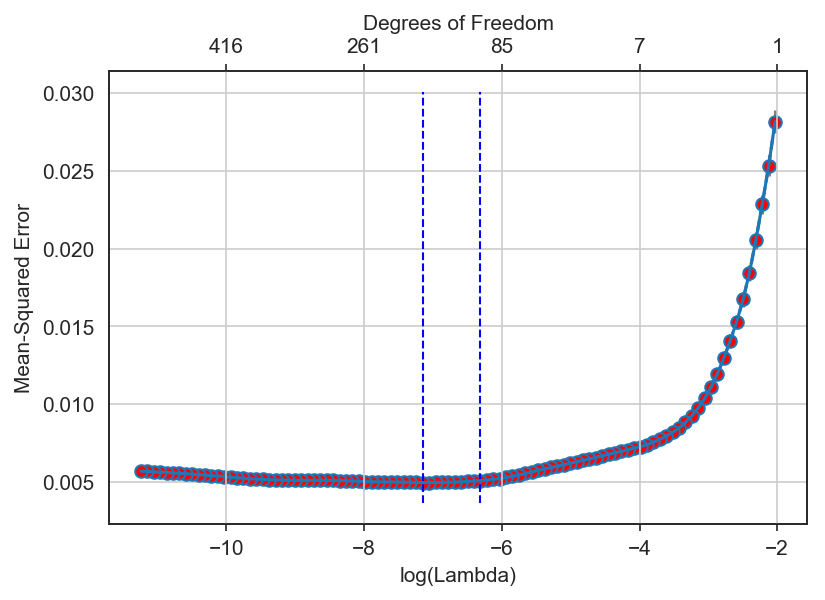

In [18]:
cvglmnetPlot(fit)

In [19]:
coefs = pd.Series(cvglmnetCoef(fit).flatten(), index=['Const'] + list(X.columns))

In [20]:
predict = cvglmnetPredict(fit, newx=X).flatten()
train_info['residual_sq'] = (train['rep_score'] - predict) ** 2
sigma2_0 = train_info.groupby('state')['residual_sq'].mean()

In [21]:
mu_0 = (test_contest.loc[:, 'rep_incumbent':].values.copy() @ coefs[1:, np.newaxis]).flatten() + coefs[0]
test_info['sigma2_0'] = test_info['state'].apply(lambda x: sigma2_0[x])

In [22]:
sigma2_0 = test_info['sigma2_0'][test_contest.index]
Sigma_0 = np.diag(sigma2_0.values)

# First update - Generic ballot

In [23]:
generic_ballot = (pd.read_csv('https://projects.fivethirtyeight.com/generic-ballot-data/generic_ballot.csv')
                  .sort_values('date', ascending=False))
generic_ballot = generic_ballot.iloc[0]
z_thresh = 1.644854
sigma2_G = ((generic_ballot['rep_hi']/100 - generic_ballot['rep_lo']/100) / 2 / z_thresh) ** 2

In [24]:
n = len(Sigma_0)
observed = generic_ballot['rep_estimate'] / (generic_ballot['rep_estimate'] + generic_ballot['dem_estimate'])
observed = np.array([observed])
mu1 = np.array([mu_0.mean()])
v1 = np.array([[sigma2_G + Sigma_0.sum() / (n ** 2)]])
v01 = np.diag(Sigma_0)[:, np.newaxis] / n

In [25]:
def normal_conditioning(mu0, mu1, v0, v1, v01, observed):
    new_mu = mu0 + v01 @ np.linalg.inv(v1) @ (observed - mu1)
    new_v = v0 - v01 @ np.linalg.inv(v1) @ v01.T
    return new_mu, new_v

In [26]:
mu_after_gen, sigma_after_gen = normal_conditioning(mu_0, mu1, Sigma_0, v1, v01, observed)

# Second update - Polls

In [27]:
polls = pd.read_feather('polls.feather')
sigma2_poll = polls.groupby(['state', 'fivethirtyeight_district'])['rep_score'].std() ** 2
sigma2_poll = sigma2_poll.fillna(sigma2_poll.mean()).reset_index()
sigma2_poll.columns = ['state','fivethirtyeight_district','sigma2_poll']
polls = polls.merge(sigma2_poll)

/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [28]:
polls = (test_info.reset_index()
         .merge(polls, how='left').dropna()
         .sort_values('created_at').groupby('index')
         .apply(lambda x: x.iloc[-3:])
         .reset_index(drop=True).drop(['sigma2_0','id','created_at'], axis=1))

In [29]:
def update_poll(poll, mu, Sigma):
    m = pd.Series(mu, index=test_contest.index)
    ind = poll['index']
    mu1 = np.array([m[ind]])
    ej = pd.Series(np.zeros(len(test_contest)), 
                  index=test_contest.index)
    ej[ind] = 1
    ej = ej.values
    cov = (Sigma @ ej)[:, np.newaxis]
    v1 = np.array([[1/4/poll['sampleSize'] + poll['sigma2_poll'] + ej.dot(Sigma @ ej)]])
    observation = poll['rep_score']
    
    return normal_conditioning(mu, mu1, Sigma, v1, cov, observation)

In [30]:
mu, Sigma = mu_after_gen.copy(), sigma_after_gen.copy()

In [31]:
mu.mean()

0.4930842360225975

In [32]:
for _, poll in tqdm(polls.iterrows()):
    mu, Sigma = update_poll(poll, mu, Sigma)

In [33]:
sim_prev = np.random.multivariate_normal(mu_after_gen, sigma_after_gen, size=100000)

In [34]:
sim = np.random.multivariate_normal(mu, Sigma, size=100000)

In [35]:
rep_uncon = df.query('raceyear==2018')['rep_uncontested'].sum()

In [36]:
(sim > .5).sum(axis=1).mean()

211.3781

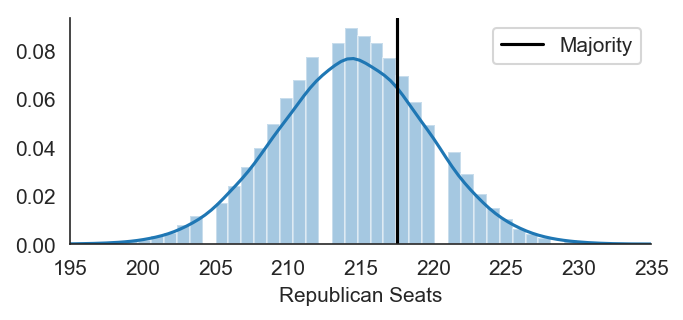

In [140]:
plt.figure(figsize=(5,2))
sns.distplot((sim > .5).sum(axis=1) + rep_uncon, bins=54, kde_kws={'bw':1})
plt.axvline(435/2, color='k', label='Majority')
plt.xlabel('Republican Seats')
plt.legend()
plt.xlim((195,235))
sns.despine()
plt.savefig('report/rep_seats.pdf')

In [141]:
1-((sim > .5).sum(axis=1) + 3 > 217.5).mean()

0.72653

In [39]:
(sim > .5).sum(axis=1).std()

5.150398080731236

In [40]:
test_info['mu'] = mu
test_info['sigma'] = np.diag(Sigma) ** .5

In [41]:
test_info['edge'] = (test_info['mu'] - .5) / test_info['sigma']

In [42]:
maps = gpd.read_file('data/kx-us-116th-congressional-districts-SHP (1)/us-116th-congressional-districts.shp')

In [43]:
def wrapper(func, x):
    try:
        return func(x)
    except:
        return None

In [44]:
maps['state_fips'] = maps['GEOID'].apply(lambda x : int(x[:2]))
maps['district'] = maps['GEOID'].apply(lambda x : wrapper(int, x[2:]))

In [45]:
maps = maps[['state_fips', 'district', 'geometry']].copy()

In [46]:
uncon = df.loc[test_uncontest.index, ['state_fips', 'district', 'rep_uncontested']].copy()

In [47]:
uncon['mu'] = uncon['rep_uncontested'].astype(float)

In [48]:
uncon['sigma'] = 0
uncon['edge'] = (uncon['mu'] - .5) * 40

In [49]:
preds = pd.concat([test_info, uncon.drop('rep_uncontested', axis=1)], sort=False)

In [50]:
final_map = maps.merge(preds, how='right', on=['state_fips', 'district'])

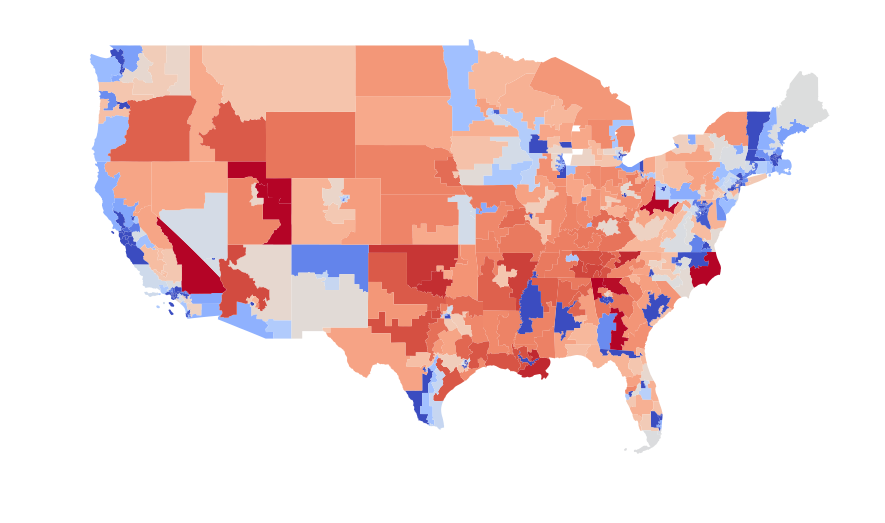

In [110]:
f, ax = plt.subplots(1, figsize=(7, 5))
final_map.query('state not in ["Alaska", "Hawaii"]')[['geometry', 'mu']]\
.plot('mu', cmap='coolwarm', vmin=0.3, vmax=.7, 
      linewidth=0, figsize=(5,5), ax=ax)

ax.set_aspect(aspect=1.3)
ax.axis('off')

plt.savefig('report/projected_map.eps')

# Produce a table of predictions

In [83]:
preds['state'] = preds['state_fips'].apply(lambda x: us.states.lookup(str(x).zfill(2)).name)

In [84]:
from scipy.stats import norm

In [85]:
def compute_prob_republican(x):
    if x['sigma'] == 0:
        return x['mu']
    else:
        return 1 - norm.cdf((.5 - x['mu']) / x['sigma'])

In [86]:
preds['republican_win_prob'] = preds.apply(compute_prob_republican, axis=1)

In [87]:
preds = preds.merge(df.query('raceyear == 2018')[['state_fips', 'district', 'rep_lastname', 'dem_lastname']])

In [88]:
preds['projected_winning_candidate'] = preds.apply(lambda x : x['rep_lastname']  + ' (R)'
                                                   if x['republican_win_prob'] > .5 
                                                   else x['dem_lastname'] + ' (D)', axis=1)


In [89]:
preds['winner_prob'] = np.maximum(preds['republican_win_prob'], 1-preds['republican_win_prob'])

In [90]:
preds['cong_district'] = preds['state'].astype(str) + '-' + preds['district'].astype(str).str.zfill(2)

In [91]:
winners = preds.sort_values(['state', 'district'])[['cong_district', 'projected_winning_candidate', 'winner_prob']].copy()
winners.columns = ['District', 'Projected Winner', 'Probability']

In [100]:
with open('report/projected_results.tex', 'w') as f:
    f.write(winners.to_latex(index=False, longtable=True))